In this tutorial we analyse how the energy in a MLP neural network (trained with PC) could be used to assess if 
test data belongs to in-distribution or out-of-distribution. We will use the energy of the network as a measure of
surprise.

1. Prepare the in-distribution (MNIST) and out-of-distribution (FashionMNIST) datasets.
    - note that the interpolation threshold for regular trainset size of (n=60000) would be (with K=10): I_th = n*K = 600 000 samples,
    one would need a 3-layer-MLP with 800 hidden nodes (h=800) to have approx. 1.2x10^6 parameters and thus be twice as big as the interpolation threshold 
    in order to guarantee not fitting a model which might below the interpolation threshold I_th or in the "classical" under-parameterized regime but 
    instead ensure to fit a model in the "modern" over-parameterized regime. We achieve this by a) training for long enough and b) ensuring that the model 
    has the appropriate capacity (i.e., number of parameters) which we control with h (i.e., the number of hidden nodes in each layer).
    - given that the complete training data (n=60000) size would require unnecessary big neural networks (increased compute time due to increased 
    hidden size h) we will use a subset of the complete training data (n_subset_size=) to make it sufficient to train networks with half the amount of 
    samples which will give use a reduce interpolation threshold of I_th (= 300 000 samples). Given fixed K (K=10 classes) we can use a 
    training subset_size n_subset_size of 30 000 samples. In this case, the required hidden size h to achieve a 3-layer-MLP with at least twice as many 
    parameters as the chosen training set size would be approx. h≈512 - which would give use a neural network with approx. 6.5x10^5 (650 000) parameters 
    (so roughly half, 6x10^5 parameters, of what we required above).
2. Training phase: Train a MLP neural network with PC on MNIST.
3. Testing phase: Test the network with MNIST and FashionMNIST.
4. Plots and tables:
    1. Plot the energy distribution histograms to visualize the distribution and spread of the energy for in-distribution and out-of-distribution 
    data, use separate histograms for each dataset and overlay them for comparison.
    2. Create box plots to show the median, quartiles, and outliers of the energies to summarize the central tendency and variability of energies.
    3. Generate a Receiver Operating Characteristic (ROC) curve based on the energies to assess the model's ability to distinguish between 
    in-distribution and out-of-distribution data. Plot true positive rate (sensitivity) against false positive rate (1-specificity) for different 
    threshold values of energies.
    4. Create a table summarizing key statistics (mean, median, standard deviation) of energies for MNIST and FashionMNIST. Include columns for 
    MNIST and FashionMNIST with rows for each statistic.
    5. Create a scatter plot of energies versus prediction confidence (max softmax value) for both MNIST and FashionMNIST. Goal is to investigate 
    the relationship/correlation between model confidence and energy value. Use different colors or markers for MNIST and FashionMNIST data points.




In [1]:
# built-in
import json
import time
import os
import argparse

# choose the GPU to use
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
# disable preallocation of memory
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"

# 3rd party
import numpy as np
import matplotlib.pyplot as plt

# own
from helpers import get_dataloaders, create_new_test_loader_with_batch_size

In [2]:
###################################### start of model related code ##########################################

from typing import Callable

# Core dependencies
import jax
import jax.numpy as jnp
import equinox as eqx
import optax
print(jax.default_backend())  # print backend type

# pcax
import pcax as px
import pcax.predictive_coding as pxc
import pcax.nn as pxnn
import pcax.functional as pxf
import pcax.utils as pxu


# Model definition
class Model(pxc.EnergyModule):
    def __init__(
        self,
        input_dim: int,
        hidden_dim: int,
        output_dim: int,
        nm_layers: int,
        act_fn: Callable[[jax.Array], jax.Array]
    ) -> None:
        super().__init__()
        self._dim_input = input_dim
        self._dim_output = output_dim
        
        self.act_fn = px.static(act_fn)

        self.layers = [pxnn.Linear(input_dim, hidden_dim)] + [
            pxnn.Linear(hidden_dim, hidden_dim) for _ in range(nm_layers - 2)
        ] + [pxnn.Linear(hidden_dim, output_dim)]
        
        self.vodes = [
            pxc.Vode((hidden_dim,)) for _ in range(nm_layers - 1)
        ] + [pxc.Vode((output_dim,), pxc.ce_energy)]

        self.vodes[-1].h.frozen = True

    def num_parameters(self):
        """
        Calculate the total number of parameters in the model.
        Args:
            model: The model object containing layers with weights and biases.
        Returns:
            int: Total number of parameters in the model.
        """
        return sum(layer.nn.weight.size + layer.nn.bias.size for layer in self.layers)

    def save(self, file_name):
        pxu.save_params(self, file_name)


    def __call__(self, x, y):
        for v, l in zip(self.vodes[:-1], self.layers[:-1]):
            x = v(self.act_fn(l(x)))
        x = self.vodes[-1](self.layers[-1](x))
        
        if y is not None:
            self.vodes[-1].set("h", y)
        return self.vodes[-1].get("u")


# Training and evaluation functions
@pxf.vmap(pxu.Mask(pxc.VodeParam | pxc.VodeParam.Cache, (None, 0)), in_axes=(0, 0), out_axes=0)
def forward(x, y, *, model: Model):
    return model(x, y)

@pxf.vmap(pxu.Mask(pxc.VodeParam | pxc.VodeParam.Cache, (None, 0)), in_axes=(0,), out_axes=(None, 0), axis_name="batch")
def energy(x, *, model: Model):
    y_ = model(x, None)
    return jax.lax.pmean(model.energy().sum(), "batch"), y_

@pxf.jit(static_argnums=0)
def train_on_batch(T: int, x: jax.Array, y: jax.Array, *, model: Model, optim_w: pxu.Optim, optim_h: pxu.Optim):
    model.train()

    # init step
    with pxu.step(model, pxc.STATUS.INIT, clear_params=pxc.VodeParam.Cache):
        forward(x, y, model=model)

    # reinitialise the optimiser state between different batches (NOTE: this is just educational and not needed here because the SGD we use is not-stateful due to lack of momentum)
    optim_h.init(pxu.Mask(pxc.VodeParam)(model))

    # inference steps
    for _ in range(T):
        with pxu.step(model, clear_params=pxc.VodeParam.Cache):
            _, g = pxf.value_and_grad(pxu.Mask(pxu.m(pxc.VodeParam).has_not(frozen=True), [False, True]), has_aux=True)(energy)(x, model=model)
        optim_h.step(model, g["model"], True)

    # learning (weight update) step
    with pxu.step(model, clear_params=pxc.VodeParam.Cache):
        _, g = pxf.value_and_grad(pxu.Mask(pxnn.LayerParam, [False, True]), has_aux=True)(energy)(x, model=model)
    optim_w.step(model, g["model"])

@pxf.jit()
def eval_on_batch(x: jax.Array, y: jax.Array, *, model: Model):
    model.eval()
    with pxu.step(model, pxc.STATUS.INIT, clear_params=pxc.VodeParam.Cache):
        y_ = forward(x, y, model=model).argmax(axis=-1)
        e = model.vodes[-1].energy()
    return (y_ == y).mean(), y_, e.mean()

@pxf.jit()
def predict_with_logits_on_batch(x: jax.Array, *, model: Model):
    model.eval()
    with pxu.step(model, pxc.STATUS.INIT, clear_params=pxc.VodeParam.Cache):
        logits_ = forward(x, None, model=model)
        y_ = logits_.argmax(axis=-1)
    # print the shape of the logits and the y_ to debug
    print(f"logits shape: {logits_.shape}, y_ shape: {y_.shape}")  # Debugging line
    return y_, logits_

def train(dl, T, *, model: Model, optim_w: pxu.Optim, optim_h: pxu.Optim):
    for x, y in dl:
        train_on_batch(T, x, jax.nn.one_hot(y, 10), model=model, optim_w=optim_w, optim_h=optim_h)
    print(f"x shape: {x.shape}, y shape: {y.shape}")  # Debugging line
      
def eval(dl, *, model: Model):
    acc = []
    es = []
    ys_ = []
    for x, y in dl:
        a, y_, e = eval_on_batch(x, jax.nn.one_hot(y, 10), model=model)
        acc.append(a)
        es.append(e)
        ys_.append(y_)
    return float(np.mean(acc)), np.concatenate(ys_), float(np.mean(es))

def predict_with_logits(dl, *, model: Model):
    ys_ = []
    logits_ = []
    for x, _ in dl:
        y_, logits = predict_with_logits_on_batch(x, model=model)
        ys_.append(y_)
        logits_.append(logits)
    return np.concatenate(ys_), np.concatenate(logits_)

# write a function that given an input and an output, finds the state of the model that minimises 
# the energy via T inference steps using the model's optimiser optim_h on the model's vodes

@pxf.jit(static_argnums=0)
def eval_inference_on_batch(T: int, x: jax.Array, y: jax.Array, *, model: Model, optim_h: pxu.Optim):
    model.eval()

    # compute the energy of the model with the given input and output before the inference steps (i.e. without minimising the energy)
    with pxu.step(model, pxc.STATUS.INIT, clear_params=pxc.VodeParam.Cache):
        forward(x, y, model=model).argmax(axis=-1)
        e_pre_ = model.vodes.energy()
    # show the shape of e_pre_ before the inference steps
    print(f"e_pre_ shape: {e_pre_.shape}")

    # shorthand for value and grad computation on the energy function
    inference_step = pxf.value_and_grad(pxu.Mask(pxu.m(pxc.VodeParam).has_not(frozen=True), [False, True]), has_aux=True)(energy)

    # init step
    with pxu.step(model, pxc.STATUS.INIT, clear_params=pxc.VodeParam.Cache):
        forward(x, y, model=model)

    # reinitialise the optimiser state between different batches (NOTE: this is just educational and not needed here because the SGD we use is not-stateful due to lack of momentum)
    optim_h.init(pxu.Mask(pxc.VodeParam)(model))

    # inference steps
    for _ in range(T):
        with pxu.step(model, clear_params=pxc.VodeParam.Cache):
            _, g = inference_step(x, model=model)
        optim_h.step(model, g["model"], True)
    # print that the function was successfully executed
    print("eval_inference_on_batch executed successfully")  # Debugging line
    

def eval_inference(dl, T, *, model: Model, optim_h: pxu.Optim):
    for x, y in dl:
        eval_inference_on_batch(T, x, jax.nn.one_hot(y, 10), model=model, optim_h=optim_h)

###################################### end of model related code ##########################################

gpu


2024-06-02 13:33:34.648193: W external/xla/xla/service/gpu/nvptx_compiler.cc:760] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.5.40). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [3]:
dataset_name = "mnist"
train_subset_size = 30000
batch_size = 128
noise_level = 0.0 # this means that the validation set will be 20% of the train_subset_size (6000 samples)
# get the dataloaders
dataset = get_dataloaders(dataset_name, train_subset_size, batch_size, noise_level)
# Check the sizes of the datasets
print(f"Training set: {len(dataset.train_loader.sampler)} samples")
print(f"Validation set: {len(dataset.val_loader.sampler)} samples")
print(f"Test set: {len(dataset.test_loader.dataset)} samples")

Training set: 30000 samples
Validation set: 6000 samples
Test set: 10000 samples


In [4]:
w_learning_rate = 1e-2
h_learning_rate = 1e-2
T = 10

# create a dummy model to see if the model is working
model = Model(
    input_dim=784,
    hidden_dim=512,
    output_dim=10,
    nm_layers=3,
    act_fn=jax.nn.gelu
)

# print the model
print(model)
# now print number of parameters in the model
print(f"Number of parameters: {model.num_parameters()}")

(Model):
  ._dim_input: 784
  ._dim_output: 10
  .layers[0].nn.weight: LayerParam([512,784], float32)
  .layers[0].nn.bias: LayerParam([512], float32)
  .layers[1].nn.weight: LayerParam([512,512], float32)
  .layers[1].nn.bias: LayerParam([512], float32)
  .layers[2].nn.weight: LayerParam([10,512], float32)
  .layers[2].nn.bias: LayerParam([10], float32)
  .vodes[0].h: VodeParam(None)
  .vodes[0].cache: Cache(params=None)
  .vodes[1].h: VodeParam(None)
  .vodes[1].cache: Cache(params=None)
  .vodes[2].h: VodeParam(None)
  .vodes[2].cache: Cache(params=None)
Number of parameters: 669706


In [5]:
nm_epochs = 5

# Initialize the model and optimizers
with pxu.step(model, pxc.STATUS.INIT, clear_params=pxc.VodeParam.Cache):
    forward(jax.numpy.zeros((batch_size, model._dim_input)), None, model=model)
    optim_h = pxu.Optim(optax.sgd(h_learning_rate), pxu.Mask(pxc.VodeParam)(model))
    optim_w = pxu.Optim(optax.sgd(w_learning_rate, momentum=0.95), pxu.Mask(pxnn.LayerParam)(model))

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
for e in range(nm_epochs):

    # train the model
    train(dataset.train_loader, T=T, model=model, optim_w=optim_w, optim_h=optim_h)
    
    # evaluate the model and get accuracies and losses
    a_train, ys_train, e_train = eval(dataset.train_loader, model=model)
    a_val, ys_val, e_val = eval(dataset.val_loader, model=model)

    train_losses.append(e_train)
    val_losses.append(e_val)
    train_accuracies.append(a_train)
    val_accuracies.append(a_val)

    print(f"Epoch {e+1}/{nm_epochs} - Train Acc: {a_train:.4f} - Val Acc: {a_val:.4f} - Train Loss: {e_train:.4f} - Val Loss: {e_val:.4f}")

a_test, ys_test, e_test = eval(dataset.test_loader, model=model)
print(f"Test Acc: {a_test:.4f} - Test Loss: {e_test:.4f}")

/users-2/amine/miniconda3/envs/pcax24/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


x shape: (128, 784), y shape: (128,)


/users-2/amine/miniconda3/envs/pcax24/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 1/5 - Train Acc: 0.8498 - Val Acc: 0.8536 - Train Loss: 0.5414 - Val Loss: 0.5402
x shape: (128, 784), y shape: (128,)
Epoch 2/5 - Train Acc: 0.8882 - Val Acc: 0.8886 - Train Loss: 0.3815 - Val Loss: 0.3844
x shape: (128, 784), y shape: (128,)
Epoch 3/5 - Train Acc: 0.9036 - Val Acc: 0.9025 - Train Loss: 0.3262 - Val Loss: 0.3308
x shape: (128, 784), y shape: (128,)
Epoch 4/5 - Train Acc: 0.9134 - Val Acc: 0.9122 - Train Loss: 0.2947 - Val Loss: 0.3068
x shape: (128, 784), y shape: (128,)
Epoch 5/5 - Train Acc: 0.9204 - Val Acc: 0.9181 - Train Loss: 0.2689 - Val Loss: 0.2855
Test Acc: 0.9209 - Test Loss: 0.2715


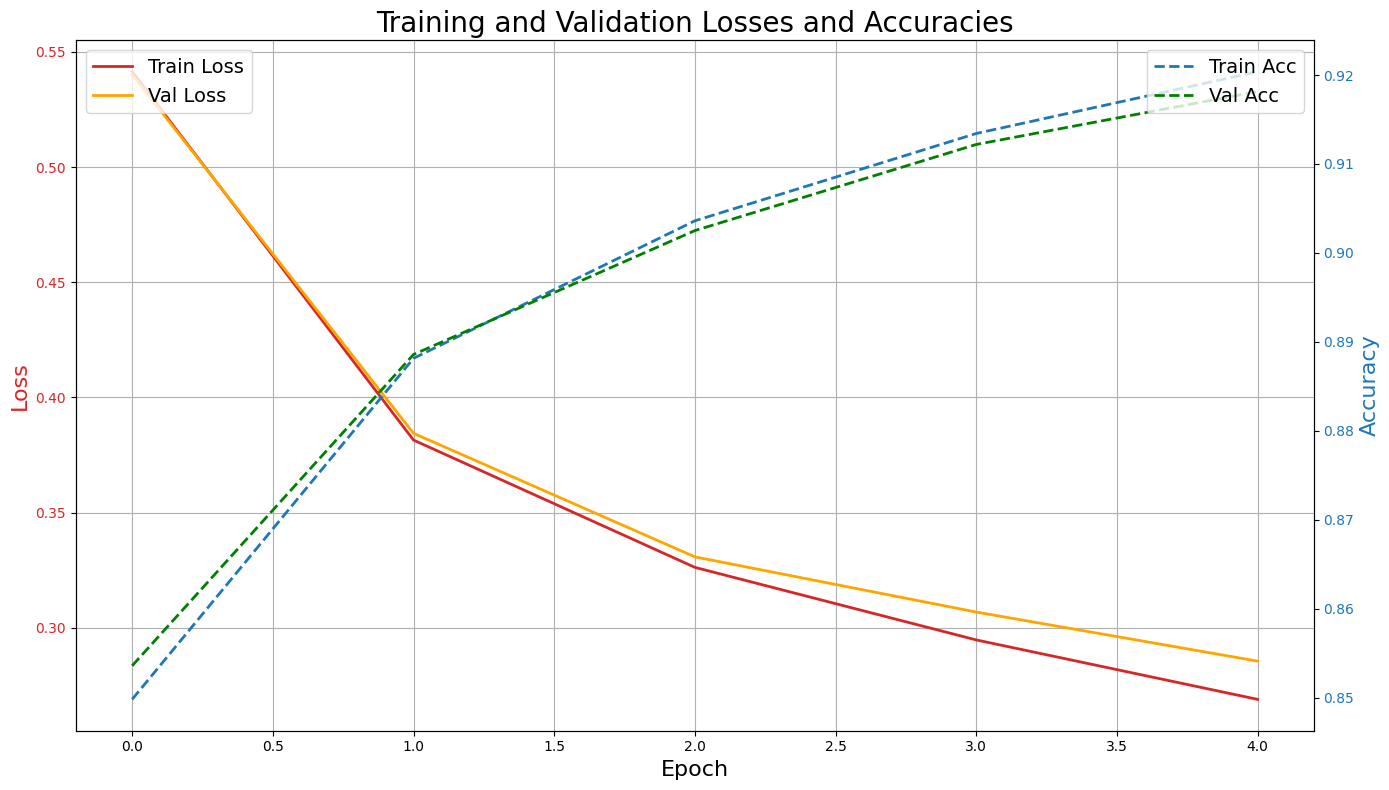

In [6]:
import matplotlib.pyplot as plt

# Assuming train_losses, val_losses, train_accuracies, val_accuracies are defined

fig, ax1 = plt.subplots(figsize=(14, 8))

# Plot training and validation losses
color = 'tab:red'
ax1.set_xlabel('Epoch', fontsize=16)
ax1.set_ylabel('Loss', fontsize=16, color=color)
ax1.plot(train_losses, color=color, label="Train Loss", linewidth=2)
ax1.plot(val_losses, color="orange", label="Val Loss", linewidth=2)
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend(loc="upper left", fontsize=14)
ax1.grid(True)

# Create a twin Axes sharing the x-axis for accuracies
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Accuracy', fontsize=16, color=color)
ax2.plot(train_accuracies, color=color, linestyle="--", label="Train Acc", linewidth=2)
ax2.plot(val_accuracies, color="green", linestyle="--", label="Val Acc", linewidth=2)
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(loc="upper right", fontsize=14)

# Title and layout adjustments
plt.title('Training and Validation Losses and Accuracies', fontsize=20)
fig.tight_layout()
plt.show()


In [7]:
# now compute the prediction and logits for the test set
ys_test, logits_test = predict_with_logits(dataset.test_loader, model=model)

# now print the shape of the logits_test and the ys_test
print(f"logits_test shape: {logits_test.shape}, ys_test shape: {ys_test.shape}")

# show the first row of the logits_test and the ys_test
print(f"logits_test[0]: {logits_test[0]}")
print()
print(f"ys_test[0]: {ys_test[0]}")

# now compute the softmax of the logits_test for the first row
logits_test_softmax = jax.nn.softmax(logits_test[0])
print(f"logits_test_softmax[0]: {logits_test_softmax}")

# now compute the sum of the logits_test_softmax
print(f"sum of the logits_test_softmax[0]: {logits_test_softmax.sum()}")

logits shape: (128, 10), y_ shape: (128,)
logits_test shape: (9984, 10), ys_test shape: (9984,)
logits_test[0]: [ 1.0100254  -6.3863034   0.42270726  2.7777958  -3.2795231  -0.28801194
 -6.446054   11.385325   -2.0851417   3.3352966 ]

ys_test[0]: 7
logits_test_softmax[0]: [3.1176030e-05 1.9126521e-08 1.7328146e-05 1.8262233e-04 4.2745836e-07
 8.5131578e-06 1.8017190e-08 9.9943954e-01 1.4112605e-06 3.1891390e-04]
sum of the logits_test_softmax[0]: 0.9999999403953552


In [8]:
# create new custom test loader with batch size equal to the entire test set
full_test_loader = create_new_test_loader_with_batch_size(test_loader=dataset.test_loader, new_batch_size=len(dataset.test_loader.dataset))

# Fetch all data from the loader
for batch in full_test_loader:
    inputs, targets = batch

# Convert to JAX arrays
X_test_jax = jnp.array(inputs)
y_test_jax = jnp.array(targets)

# Print shapes to verify
print(f"X_test_jax shape: {X_test_jax.shape}")
print(f"y_test_jax shape: {y_test_jax.shape}")

/users-2/amine/miniconda3/envs/pcax24/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


X_test_jax shape: (10000, 784)
y_test_jax shape: (10000,)


In [9]:
# clear VodeParams, we need to do this because the batch_size of full_test_loader (entire test set, 10000 samples) is different from the batch_size of the test_loader (actual batch size used during training)
model.clear_params(pxc.VodeParam)

# now compute the prediction and logits for the full_test_loader
ys_test, logits_test = predict_with_logits(full_test_loader, model=model)

# Convert the outputs to JAX arrays
ys_test_jax = jnp.array(ys_test)
logits_test_jax = jnp.array(logits_test)

# now print the shape of the logits_test and the ys_test
print(f"logits_test shape: {logits_test.shape}, ys_test shape: {ys_test.shape}")

# show the first row of the logits_test and the ys_test
print(f"logits_test[0]: {logits_test[0]}")
print()
print(f"ys_test[0]: {ys_test[0]}")

# now compute the softmax of the logits_test for the first row
logits_test_softmax = jax.nn.softmax(logits_test[0])
print(f"logits_test_softmax[0]: {logits_test_softmax}")

# now compute the sum of the logits_test_softmax
print(f"sum of the logits_test_softmax[0]: {logits_test_softmax.sum()}")

logits shape: (10000, 10), y_ shape: (10000,)
logits_test shape: (10000, 10), ys_test shape: (10000,)
logits_test[0]: [ 1.0100255  -6.386304    0.42270738  2.7777972  -3.279524   -0.28801283
 -6.4460554  11.38533    -2.0851433   3.3352969 ]

ys_test[0]: 7
logits_test_softmax[0]: [3.1175881e-05 1.9126448e-08 1.7328062e-05 1.8262181e-04 4.2745592e-07
 8.5131096e-06 1.8017053e-08 9.9943954e-01 1.4112511e-06 3.1891238e-04]
sum of the logits_test_softmax[0]: 0.9999999403953552


In [10]:
T_inf = 50
# now run T inference steps on the full test set pair of test images X_test_jax and predictions ys_test_jax (note that these need to be supplied as JAX arrays) using eval_inference_on_batch()
eval_inference_on_batch(T_inf, X_test_jax, jax.nn.one_hot(ys_test_jax, 10), model=model, optim_h=optim_h)

eval_inference_on_batch executed successfully
